In [1]:
import pandas as pd

df = pd.read_csv('DataTrain/train_preprocess.tsv', delimiter='\t', header=None, )
df.columns=['text', 'label']
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [2]:
df.head

<bound method NDFrame.head of                                                     text     label
0      warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1      mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2      lokasi strategis di jalan sumatera bandung . t...  positive
3      betapa bahagia nya diri ini saat unboxing pake...  positive
4      duh . jadi mahasiswa jangan sombong dong . kas...  negative
...                                                  ...       ...
10995                                       tidak kecewa  positive
10996  enak rasa masakan nya apalagi kepiting yang me...  positive
10997        hormati partai-partai yang telah berkoalisi   neutral
10998  pagi pagi di tol pasteur sudah macet parah , b...  negative
10999  meskipun sering belanja ke yogya di riau junct...  positive

[11000 rows x 2 columns]>

In [3]:
df.shape

(11000, 2)

In [4]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

In [5]:
import re
def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [6]:
df['text_clean'] = df.text.apply(cleansing)

In [7]:
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


In [8]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [9]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


In [10]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [11]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [12]:
from sklearn.model_selection import train_test_split
file = open("x_pad_sequences.pickle", 'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle", 'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [13]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [14]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
880/880 [==============================] - 163s 178ms/step - loss: 0.4568 - accuracy: 0.8208 - val_loss: 0.3719 - val_accuracy: 0.8545
Epoch 2/10
880/880 [==============================] - 155s 176ms/step - loss: 0.2016 - accuracy: 0.9249 - val_loss: 0.3451 - val_accuracy: 0.8727
Epoch 2: ea

In [16]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 2s 17ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       685
           1       0.88      0.67      0.76       233
           2       0.90      0.93      0.92      1282

    accuracy                           0.87      2200
   macro avg       0.86      0.81      0.83      2200
weighted avg       0.87      0.87      0.87      2200



In [22]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42, shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test   = X[data[1]]
    target_test = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 2s 17ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       685
           1       0.86      0.76      0.81       233
           2       0.88      0.95      0.91      1282

    accuracy                           0.88      2200
   macro avg       0.87      0.83      0.85      2200
weighted avg       0.88      0.88      0.87      2200

69/69 [==============================] - 2s 17ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       685
           1       0.77      0.85      0.81       233
           2       0.93      0.87      0.90      1282

    accuracy                           0.86      2200
   macro avg       0.83      0.86      0.84      2200
weighted avg       0.87      0.86      0.87      2200

69/69 [==============================] - 2s 19ms/step
Training ke- 3
              precision    reca

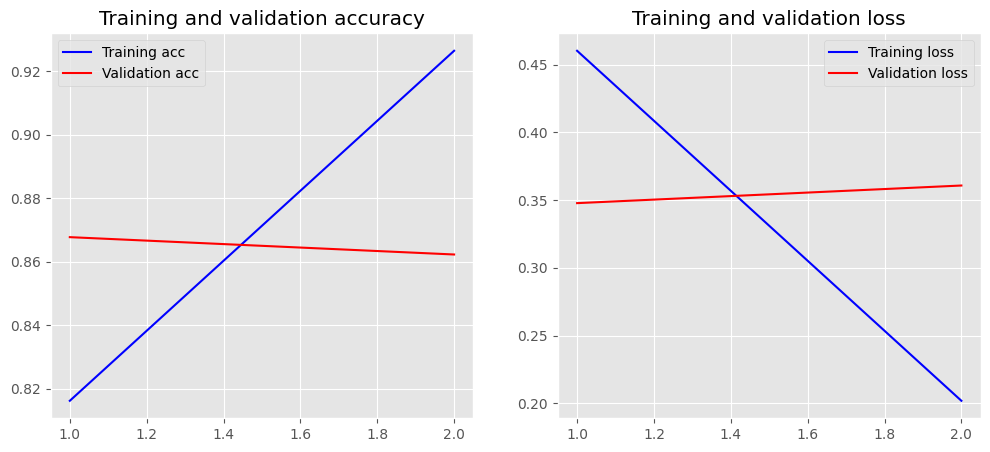

In [23]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [24]:
model.save('model.h5')
print("Model has created!")

Model has created!


In [25]:
import re
from keras.models import load_model

input_text = """
Rasa syukur, cukup.
"""

def cleansing(sent):

    string = sent.lower()

    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [26]:
sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 1s 676ms/step
Text:   rasa syukur  cukup  
Sentiment:  positive
